__This Jupyter Notebook is an entry to Technical Assignment (Data Science) for Apigate, January 2020.__

Author: Ahmad Lokman Anuar

__Question 2__

Apply machine learning technique to predict any interesting topic of this.

__Problem of Choice__

We will use ML method to predict the case of flight delays based on Carrier On-TIme Performance Report (Nov 2019) for all flights in the US. Available from https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

General work flow: 

1. Environment setup, load dataset, and review data.
2. Clean-up to organize data.
3. Descriptive Analysis to summarize data.
4. Implement ML classifiers.
5. Evaluate performance

__1. Environment Setup, Load Dataset, Review data__

In [1]:
library(readr)
library(tibble)

flights <- read.csv2('./404528202_T_ONTIME_REPORTING/404528202_T_ONTIME_REPORTING.csv', sep=",", header=TRUE, stringsAsFactors = FALSE)
# View top of dataset
head(flights)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,X
,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>,...,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,1,5,YV,20378,YV,N905J,5984,11298,1129806,DFW,...,AMA,1435,0.00,1400-1459,1544,0.00,0.00,0.00,312.00,NA
2,1,5,YV,20378,YV,N950LR,5987,11298,1129806,DFW,...,ABQ,831,1.00,0700-0759,914,1.00,0.00,0.00,569.00,NA
3,1,5,YV,20378,YV,N916FJ,5988,13891,1389101,ONT,...,PHX,959,0.00,1000-1059,1107,0.00,0.00,0.00,325.00,NA
4,1,5,YV,20378,YV,N916FJ,5988,14107,1410702,PHX,...,ONT,736,0.00,0700-0759,857,0.00,0.00,0.00,325.00,NA
5,1,5,YV,20378,YV,N919FJ,5989,11298,1129806,DFW,...,BMI,1918,1.00,1800-1859,2106,0.00,0.00,0.00,690.00,NA
6,1,5,YV,20378,YV,N905J,5990,10627,1062702,BIS,...,DFW,644,0.00,0600-0659,909,0.00,0.00,0.00,977.00,NA


We will try to observe the whole dataset contents and dimension using simple $print$. 

In [2]:
print(flights)

     DAY_OF_MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID
1               1           5                YV                 20378
2               1           5                YV                 20378
3               1           5                YV                 20378
4               1           5                YV                 20378
5               1           5                YV                 20378
6               1           5                YV                 20378
7               1           5                YV                 20378
8               1           5                YV                 20378
9               1           5                YV                 20378
10              1           5                YV                 20378
11              1           5                YV                 20378
12              1           5                YV                 20378
13              1           5                YX                 20452
14              1   

It is observed that the dataset is very large and exceed maximum limit of print. Over 500,000 rows omitted from view.


__2. Clean-up and Organize Data.__

As the downloaded dataset dimension is overwhelming (over 600,000+ rows of data), the dataset will be randomly downsampled to take 5% of total rows.


In [3]:
library(dplyr)

set.seed(10) #seed number is set to ensure reproducibility


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
flightsampled <- sample_frac(flights,0.05) #random downsample 5%

In [5]:
print(flightsampled) #Inspect full dataset dimension.

     DAY_OF_MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID
1              24           7                B6                 20409
2              21           4                B6                 20409
3               9           6                UA                 19977
4              26           2                9E                 20363
5              19           2                OO                 20304
6               5           2                HA                 19690
7              30           6                DL                 19790
8               6           3                WN                 19393
9              21           4                YX                 20452
10              6           3                AA                 19805
11             27           3                WN                 19393
12             26           2                DL                 19790
13             20           3                YV                 20378
14              5   

At the bottom section, we know the dataset was downsampled to over 25,000 rows. For fast execution, we take this size as fit for analysis.

In [6]:
# Group flights 

ontime <- flightsampled[!is.na(flightsampled$ARR_DEL15) & flightsampled$ARR_DEL15!="" & !is.na(flightsampled$DEP_DEL15) & flightsampled$DEP_DEL15!="",]

Change the data class of the filtered data to enable data processing and running algorithms.

In [7]:
ontime$DAY_OF_WEEK <- as.factor(ontime$DAY_OF_WEEK)
ontime$DISTANCE <- as.integer(ontime$DISTANCE)
ontime$CANCELLED <- as.integer(ontime$CANCELLED)
ontime$DIVERTED <- as.integer(ontime$DIVERTED)
ontime$ORIGIN <- as.factor(ontime$ORIGIN)
ontime$DEP_TIME_BLK <- as.factor(ontime$DEP_TIME_BLK)
ontime$OP_CARRIER <- as.factor(ontime$OP_CARRIER)
ontime$ARR_DEL15 <- as.factor(ontime$ARR_DEL15)
ontime$DEP_DEL15 <-as.factor(ontime$DEP_DEL15)
ontime$DEST <- as.factor(ontime$DEST)

__3. Sample Descriptive Analysis to summarize data.__



The following plot looks for delays by day of week, it’s observed that distribution of delay incidence is generally uniform with slight difference across days of the week. 

However the day-7 (Saturday) records higher delay incidence. Multiple reasons can be attributed to this, for example high influx of travellers for the start of weekend.

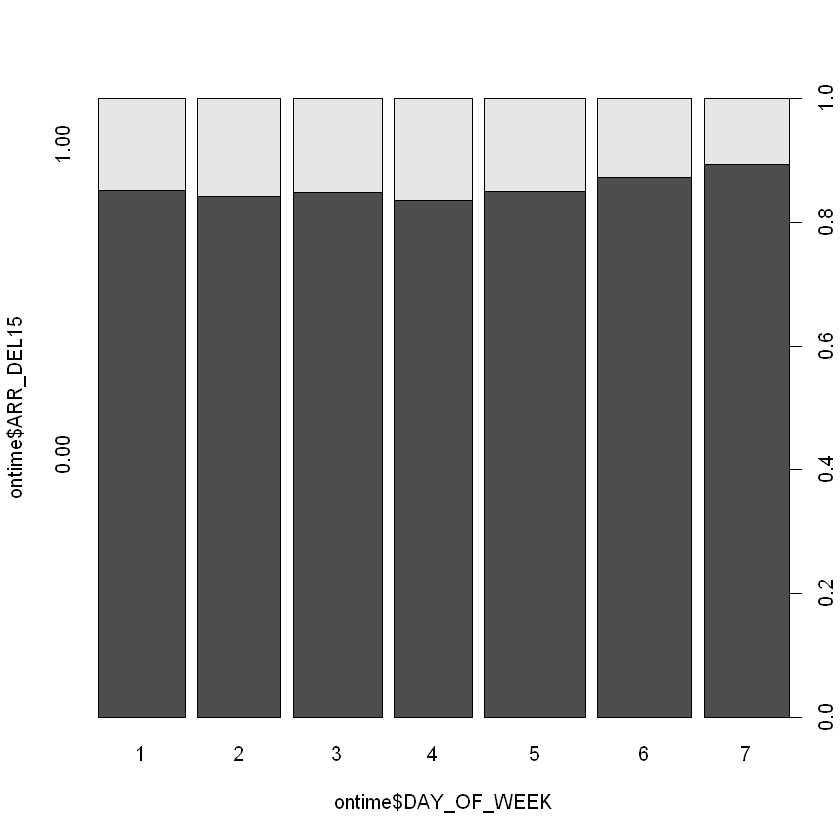

In [8]:
plot(ontime$ARR_DEL15 ~ ontime$DAY_OF_WEEK)

__4. Implement ML Classifiers__

The following code shows the creation of the training and testing data.

In [9]:
# PART 2: TRAINING DATA

library(caret)

Loading required package: lattice

Loading required package: ggplot2



In [10]:
set.seed(13) 

# Select columns to be used in algorithm training

feature<- c("ARR_DEL15", "DAY_OF_WEEK", "OP_CARRIER", "DEST","ORIGIN","DEP_TIME_BLK")

# Created sorted version of the ontime data

ontime_sorted <- ontime[,feature] 

# Select data to put into training

training_index <- createDataPartition(ontime_sorted$ARR_DEL15, p=0.75, list=FALSE)

# Create training & testing dataset

training_data <- ontime_sorted[training_index,] 
testing_data <- ontime_sorted[training_index,] 

__Model Evaluation and Results__

We implement one classifier for fast execution of the dataset. Our algorithm of choice is Logistic Regression.

In [11]:
# METHOD 1: Logistic Regression

log_reg_mod <- train(ARR_DEL15 ~ ., data = training_data, method = "glm", family = "binomial",
                     trControl=trainControl(method = "cv", number = 5, repeats = 5))

# Predict

log_reg_predict <- predict(log_reg_mod, testing_data)

# Confusion matrix 

confusion_matrix_reg <- confusionMatrix(log_reg_predict, testing_data[,"ARR_DEL15"])
confusion_matrix_reg

Warning message:
"`repeats` has no meaning for this resampling method."
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message:
"glm.fit: fitted probabilit

Confusion Matrix and Statistics

          Reference
Prediction  0.00  1.00
      0.00 19139  3170
      1.00    34    53
                                          
               Accuracy : 0.8569          
                 95% CI : (0.8523, 0.8615)
    No Information Rate : 0.8561          
    P-Value [Acc > NIR] : 0.3631          
                                          
                  Kappa : 0.0246          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.99823         
            Specificity : 0.01644         
         Pos Pred Value : 0.85790         
         Neg Pred Value : 0.60920         
             Prevalence : 0.85609         
         Detection Rate : 0.85457         
   Detection Prevalence : 0.99612         
      Balanced Accuracy : 0.50734         
                                          
       'Positive' Class : 0.00            
                  


Conclusion

The logistic regression model has an accuracy rate of 85 %. It is logical, because using small downsampled of dataset which further used for training and testing will create bias. However, it is sufficient for the purpose of demonstration.

Future Improvements

- The model can be made better by implementing __hyperparameter tuning__ the Logistic Regression package to find best parameter. 
- The model can also be optimized through __Ensemble Method__ where different algorithms will consolidate their weightage to a unified model which has compounded performance.
- __Feature Engineering__ can also increase the quality of dataset and unearth more correlation between features.